Gender Biases in Student Evaluations of Teachers
====================================================


In [1]:
# boilerplate
%matplotlib inline
import math
import numpy as np
import pandas as pd
from numpy.random import random
import scipy as sp
from scipy import special
import matplotlib.pyplot as plt
from __future__ import division
# import permute #Install instructions at https://github.com/statlab/permute

# initialize PRNG
rs = np.random.RandomState(seed=1)

Permutation test code
============

In [2]:
def corr(x, y, reps=10**4, rs=None):
    '''
    Simulate permutation p-value for Spearman correlation coefficient
    Returns test statistic, simulations, left-sided p-value, right-sided p-value, two-sided p-value
    '''
    if rs == None:
        rs = np.random.RandomState()
    t = np.corrcoef(x, y)[0,1]
    sims = [np.corrcoef(rs.permutation(x), y)[0,1] for i in range(reps)]
    return t, np.sum(sims <= t)/reps, np.sum(sims >= t)/reps, np.sum(np.abs(sims) >= math.fabs(t))/reps, sims

def stratCorrTst(x, y, group):
    '''
    Calculates sum of Spearman correlations between x and y, computed separately in each group.
    '''
    tst = 0.0
    for g in np.unique(group):
        gg = (group == g)
        tst += np.corrcoef(x[gg], y[gg])[0,1]
    return tst

def permuteWithinGroups(x, group, rs=None):
    '''
    Permutes the elements of x within groups
    Input: ndarray x to be permuted, ndarray group of group ids, np.random.RandomState object rs
    '''
    if rs == None:
        rs = np.random.RandomState()
    permuted = x.copy()
    for g in np.unique(group):
        gg = group == g
        permuted[gg] = rs.permutation(permuted[gg])      
    return permuted

def stratCorr(x, y, group, rs, reps=10**4):
    '''
    Simulate permutation p-value of stratified Spearman correlation test.
    Returns test statistic, simulations, left-sided p-value, right-sided p-value, two-sided p-value
    '''
    t = stratCorrTst(x, y, group)
    sims = [stratCorrTst(permuteWithinGroups(x, group, rs), y, group) for i in range(reps)]
    return t, np.sum(sims <= t)/reps, np.sum(sims >= t)/reps, np.sum(np.abs(sims) >= math.fabs(t))/reps, sims


## Read data and define new fields

In [3]:
dat = pd.read_stata("../../SET data/permutation_full.dta",  convert_categoricals=False )
#dat = dat[dat.admission_cep == 0]
dat.describe()

,student_id,year,dual_degree,entreescpoen,stu_male,stu_female,admission_exam,admission_cep,admission_bactb,admission_other,...,scpo,both_female,both_male,stumale_proffemale,stufemale_profmale,diff_final_cont,fall,spring,three_evals,sum_q10
count,22665.000000,22665.000000,22665.000000,22665.00000,22665.000000,22665.000000,22647.000000,22647.000000,22647.00000,22647.000000,...,22665.000000,22665.000000,22665.000000,22665.000000,22665.000000,22502.000000,22665.000000,22665.000000,22665.000000,22665.000000
mean,2381.468652,2010.239268,0.100993,2010.18844,0.433179,0.566821,0.674306,0.133704,0.11220,0.031527,...,0.109243,0.177101,0.295345,0.137834,0.389720,1.601022,0.589852,0.410148,0.864858,6.462696
std,1232.740116,1.345684,0.301326,1.36306,0.495526,0.495526,0.468644,0.340342,0.31562,0.174742,...,0.311951,0.381763,0.456208,0.344733,0.487697,2.793144,0.491871,0.491871,0.341883,1.693313
min,1.000000,2008.000000,0.000000,2004.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-9.500000,0.000000,0.000000,0.000000,1.000000
25%,1391.000000,2009.000000,0.000000,2009.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-0.500000,0.000000,0.000000,1.000000,6.000000
50%,2453.000000,2010.000000,0.000000,2010.00000,0.000000,1.000000,1.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.500000,1.000000,0.000000,1.000000,7.000000
75%,3420.000000,2011.000000,0.000000,2011.00000,1.000000,1.000000,1.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,1.000000,0.000000,1.000000,3.500000,1.000000,1.000000,1.000000,8.000000
max,4423.000000,2012.000000,1.000000,2012.00000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,16.000000,1.000000,1.000000,1.000000,9.000000


In [4]:
evals = ['q16', 'q1', 'q2', 'q3', 'q4', 'q5', 'q6', 'q7', 'q8', 'q9', 'q10', 'q13', 'q14', 'q15']
if isinstance(dat.q16[0], str):
    for e in evals:
        dat[e].replace(['nonpertinent', 'insuffisant', 'moyen', 'bon', 'excellent'],\
                       [0,1,2,3,4],\
                       inplace=True)
    
dat['course'] = dat['prof_id']
dat['course'][dat['history']==1] = 'history' 
dat['course'][dat['micro']==1] = 'micro' 
dat['course'][dat['ip']==1] = 'ip' 
dat['course'][dat['macro']==1] = 'macro' 
dat['course'][dat['socio']==1] = 'socio' 
dat['course'][dat['scpo']==1] = 'scpo' 

dat['gender'] = dat.prof_male
dat['gender'][dat.gender==1] = 'M'
dat['gender'][dat.gender==0] = 'F'
dat['student_gender'] = dat.stu_male
dat['student_gender'][dat.student_gender==1] = 'M'
dat['student_gender'][dat.student_gender==0] = 'F'

# Defining the fun times for class
dat['plumTime'] = (dat['extremetime'] < 2) & dat['day'].isin([2,3,4])

C:\Users\albor_000\Anaconda\lib\site-packages\IPython\kernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\albor_000\Anaconda\lib\site-packages\IPython\kernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\albor_000\Anaconda\lib\site-packages\IPython\kernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\albor_000\Anaconda\lib\site-packages\IPython\kernel\__main__.py:10: SettingWithCopyWarning: 
A value is tryin

## Data filtering

Most of the analyses omit grades in PI, for two reasons: 
1. The final exam is oral
2. There is a large imbalance in the gender of the instructors: 52 male, 12 female
3. Since the course is "easy," that would bias results in favor of making male instructors look more effective

In [5]:
# remove the Political Institutions courses
datNoIp = dat.copy()
datNoIp = datNoIp[datNoIp['course'] != 'ip']

# Start of the analysis

### Is there a significant association between ratings and student performance?

In [6]:
# test association between ratings and performance, pooled genders.
# Since this uses the final exams, eliminate the IP courses

# group the data by instructor, discipline, gender, student gender

grouped = datNoIp.groupby(['prof_id', 'course', 'gender', 'student_gender'])
prof_ratings = grouped[evals].mean()

pass_fail = lambda x: np.mean([xx >= 10 for xx in x])
pass_rate = grouped['note_finale'].agg([np.mean,pass_fail])

teacher_data = pd.concat([prof_ratings, pass_rate], axis=1)
teacher_data = teacher_data.rename(columns = {'mean':'mean_final_exam', '<lambda>':'pass_rate'}).reset_index()

# Test association between ratings performance, pooled genders.
(t, plower, pupper, pboth, sims) = corr(x = teacher_data.q16, y = teacher_data.mean_final_exam, rs = rs)
print 'Ratings v. performance, pooled gender:',t, plower, pupper, pboth

# Test association between ratings performance, stratified by gender.
(t, plower, pupper, pboth, sims) = stratCorr(x = teacher_data.q16, y = teacher_data.mean_final_exam,
                                            group = teacher_data.gender, rs = rs)
print 'Ratings v. performance, stratified by gender:', t, plower, pupper, pboth

Ratings v. performance, pooled gender: 0.0528246155307 0.9245 0.0755 0.1541
Ratings v. performance, stratified by gender: 0.0844164315315 0.862 0.138 0.2735


### Ratings v instructor gender

In [7]:
grouped = dat.groupby(['prof_id'])
theCols = evals + ['prof_male']  # evaluation columns, plus indicator for male prof

prof_ratings = grouped[theCols].agg(np.mean)

(t, plower, pupper, pboth, sims) = corr(x = prof_ratings.q16, y = prof_ratings.prof_male, rs = rs)

print 'mean rating for instructors vs. instructor gender (positive favors males):', t, plower, pupper, pboth

mean rating for instructors vs. instructor gender (positive favors males): 0.105247396725 0.9751 0.0249 0.0463


### Instructor gender and student performance

In [37]:
# remove students who took triads from instructors all of the same gender
# Since this uses final exams, remove IP courses

datNonzeroVar = datNoIp.copy()
for g in np.unique(dat['student_id']):
    gg = dat['student_id'] == g
    if (np.var(dat['note_cm'][gg]) == 0.0) or (np.var(dat['prof_male'][gg]) == 0.0):
        datNonzeroVar = datNonzeroVar.drop(datNonzeroVar[datNonzeroVar['student_id'] == g].index)

(t, plower, pupper, pboth, sims) = stratCorr(x = datNonzeroVar[~np.isnan(datNonzeroVar['note_cm'])]['prof_male'], 
                                            y = datNonzeroVar[~np.isnan(datNonzeroVar['note_cm'])]['note_cm'],
                                            group = datNonzeroVar['student_id'], rs = rs, reps=10**3)
                                           
print 'Student-level association between instructor gender and performance:', t, plower, pupper, pboth

Student-level association between instructor gender and performance: nan 0.0 0.0 0.0


### Association between instructor gender and evaluation scores, by subject

In [9]:
# Analyzing the correlation of avg evaluation score and gender, by course.  Includes IP courses.

print 'Analyzing the correlation btw avg evaluation score and gender, by course' 

theCols = evals + ['prof_male','plumTime']

grouped = dat.groupby(['prof_id'])
prof_ratings = grouped[theCols].agg(np.mean)
(t, plow, pupper, pboth, sims) = corr(x = prof_ratings.q16, y = prof_ratings.prof_male, rs = rs)
print 'overall', t, pupper, prof_ratings['prof_male'].sum(), \
      (1-prof_ratings['prof_male']).sum(),\
       prof_ratings['prof_male'].size, '\n'

for topic in np.unique(dat.course):
    perTopic = dat[dat['course']==topic]
    grouped = perTopic.groupby(['prof_id'])
    prof_ratings = grouped[theCols].agg(np.mean)
    (t, plow, pupper, pboth, sims) = corr(x = prof_ratings.q16, y = prof_ratings.prof_male, rs = rs)
    print topic, t, pupper, prof_ratings['prof_male'].sum(), \
    (1-prof_ratings['prof_male']).sum(),  prof_ratings['prof_male'].size   

Analyzing the correlation btw avg evaluation score and gender, by course
overall 0.105247396725 0.0225 248.0 124.0 372 

history 0.236576663364 0.0267 48.0 22.0 70
ip 0.170882047846 0.0947 52.0 12.0 64
macro 0.0609504012549 0.2869 61.0 31.0 92
micro -0.0230693917822 0.5813 58.0 36.0 94
scpo 0.122107762772 0.2018 33.0 15.0 48
socio 0.0117124051268 0.4674 30.0 26.0 56


### Association between evaluation scores and class meeting time

In [10]:
# Analyzing the correlation btw avg evaluation score and desirable time, by course. Includes IP courses
print 'Analyzing the correlation btw avg evaluation score and desirable time, by course' 

theCols = evals + ['prof_male','plumTime']

grouped = dat.groupby(['course_number'])
prof_ratings = grouped[theCols].agg(np.mean)
(t, plow, pupper, pboth, sims) = corr(x = prof_ratings.q16, y = prof_ratings.plumTime, rs = rs)
print 'overall', t, pupper, prof_ratings['plumTime'].sum(), \
      (1-prof_ratings['plumTime']).sum(),\
       prof_ratings['plumTime'].size, '\n'

for topic in np.unique(dat.course):
    perTopic = dat[dat['course']==topic]
    grouped = perTopic.groupby(['course_number'])
    prof_ratings = grouped[theCols].agg(np.mean)
    (t, plow, pupper, pboth, sims) = corr(x = prof_ratings.q16, y = prof_ratings.plumTime, rs = rs)
    print topic, t, pupper, prof_ratings['plumTime'].sum(), \
    (1-prof_ratings['plumTime']).sum(),  prof_ratings['plumTime'].size

Analyzing the correlation btw avg evaluation score and desirable time, by course
overall 0.0204806118802 0.2341 432 745 1177 

history -0.0195341832805 0.6196 90 134 224
ip -0.0600664348447 0.8164 75 152 227
macro 0.0243616949266 0.3605 77 152 229
micro -0.00108273545205 0.5063 81 145 226
scpo 0.0152583150004 0.4303 53 82 135
socio 0.173057340922 0.0214 56 80 136


### Association between instructors' average ratings and average continuous assessment grades

In [18]:
# Analyzing the correlation btw avg evaluation score and avg cont assessment grades, by instructor. 
# Includes IP courses

print 'Analyzing the correlation btw avg evaluation score and cont assessment, by instructor' 

theCols = evals + ['prof_male','plumTime','note_conf']

grouped = dat.groupby(['prof_id'])
prof_ratings = grouped[theCols].agg(np.mean)
(t, plow, pupper, pboth, sims) = corr(x = prof_ratings.q16, y = prof_ratings.note_conf, rs = rs)
print 'overall', t, pupper,\
       prof_ratings['note_conf'].size, '\n'

for topic in np.unique(dat.course):
    perTopic = dat[dat['course']==topic]
    grouped = perTopic.groupby(['prof_id'])
    prof_ratings = grouped[theCols].agg(np.mean)
    (t, plow, pupper, pboth, sims) = corr(x = prof_ratings.q16, y = prof_ratings.note_conf, rs = rs)
    print topic, t, pupper, prof_ratings['note_conf'].size
    
    

Analyzing the correlation btw avg evaluation score and cont assessment, by instructor
overall 0.0339705120032 0.2511 372 

history 0.230161612418 0.0256 70
ip -0.0260723288441 0.5782 64
macro 0.232746688753 0.0128 92
micro 0.128885465346 0.1077 94
scpo 0.120833856289 0.2072 48
socio 0.194304589162 0.0751 56


### Association between concordance of student and teacher genders and overall satisfaction

In [19]:
# Association between concordance of student and teacher genders and overall satisfaction. Includes IP courses.
# Male instructors first

dMale = dat[dat['prof_male']==1]
dFemale = dat[dat['prof_female']==1]

(t, plow, pupper, pboth, sims) = corr(x=dMale['q16'], y=dMale['stu_male'], reps=10**5, rs=rs)
print 'Male instructors:', t, pupper

# Female instructors

(t, plow, pupper, pboth, sims) = corr(x=dFemale['q16'], y=dFemale['stu_female'], reps=10**5, rs=rs)
print 'Female instructors:', t, pupper

Male instructors: 0.0831445895209 0.0
Female instructors: -0.00233685533328 0.57445


## Association between student grades and teacher gender, by student

### Start with continuous assessment scores

In [20]:
# Analyzing the correlation btw avg evaluation score and avg cont assessment grades, by course number.
# Since this is in contrast to the using the final exam as a measure of instructor value-added, omit IP courses
print 'Analyzing the correlation btw avg evaluation score and cont assessment, by course number; no IP' 

theCols = evals + ['prof_male','plumTime','note_conf']

grouped = datNoIp.groupby(['course_number'])
prof_ratings = grouped[theCols].agg(np.mean)
(t, plow, pupper, pboth, sims) = corr(x = prof_ratings['q16'], y = prof_ratings['note_conf'], rs = rs)
print 'overall', t, pupper,\
       prof_ratings['note_conf'].size, '\n'

for topic in np.unique(datNoIp['course']):
    perTopic = datNoIp[datNoIp['course']==topic]
    grouped = perTopic.groupby(['course_number'])
    prof_ratings = grouped[theCols].agg(np.mean)
    (t, plow, pupper, pboth, sims) = corr(x = prof_ratings['q16'], y = prof_ratings['note_conf'], rs = rs)
    print topic, t, pupper, prof_ratings['note_conf'].size
    
    

Analyzing the correlation btw avg evaluation score and cont assessment, by course number; no IP
overall 0.12306299682 0.0001 950 

history 0.322874961577 0.0 224
macro 0.229445210663 0.0004 229
micro 0.186667201697 0.002 226
scpo 0.169692942424 0.0236 135
socio 0.269476214441 0.0006 136


In [21]:
# Analyzing the correlation btw avg evaluation score and final exam grade, by course number. Omit IP courses

print 'Analyzing the correlation btw avg evaluation score and final exam grade, by course number' 

theCols = evals + ['prof_male','plumTime','note_cm']

grouped = datNoIp.groupby(['course_number'])
prof_ratings = grouped[theCols].agg(np.mean)
(t, plow, pupper, pboth, sims) = corr(x = prof_ratings['q16'], y = prof_ratings['note_cm'], rs = rs)
print 'overall', t, pupper,\
       prof_ratings['note_cm'].size, '\n'

for topic in np.unique(datNoIp.course):
    perTopic = datNoIp[datNoIp['course']==topic]
    grouped = perTopic.groupby(['course_number'])
    prof_ratings = grouped[theCols].agg(np.mean)
    (t, plow, pupper, pboth, sims) = corr(x = prof_ratings['q16'], y = prof_ratings['note_cm'], rs = rs)
    print topic, t, pupper, prof_ratings['note_cm'].size

Analyzing the correlation btw avg evaluation score and final exam grade, by course number
overall -0.0187120576315 0.7182 950 

history 0.0348491783782 0.297 224
macro 0.116619238606 0.0393 229
micro 0.117591704876 0.0391 226
scpo 0.00229264434087 0.4989 135
socio 0.0613407926159 0.2359 136


In [22]:
# Analyzing the correlation of avg teaching dimension scores and final exam grade, by course number.
# Since this uses final, omit IP courses

print 'Analyzing the correlation btw teaching dimension scores and final exam grade, by course number' 

theCols = evals + ['prof_male','plumTime','note_cm']

grouped = datNoIp.groupby(['course_number'])
prof_ratings = grouped[theCols].agg(np.mean)
(t, plow, pupper, pboth, sims) = corr(x = prof_ratings['q5'], y = prof_ratings['note_cm'], rs = rs)

print 'overall', t, pupper,\
       prof_ratings['note_cm'].size, '\n'

for topic in np.unique(datNoIp.course):
    perTopic = datNoIp[datNoIp['course']==topic]
    grouped = perTopic.groupby(['course_number'])
    prof_ratings = grouped[theCols].agg(np.mean)
    (t, plow, pupper, pboth, sims) = corr(x = prof_ratings['q5'], y = prof_ratings['note_cm'], rs = rs)
    print topic, t, pupper, prof_ratings['note_cm'].size

Analyzing the correlation btw teaching dimension scores and final exam grade, by course number
overall -0.052207480733 0.9422 950 

history -0.035271381641 0.6992 224
macro 0.0812193550034 0.1141 229
micro 0.0786543480669 0.1186 226
scpo 0.0550156342365 0.2667 135
socio 0.0821015630437 0.1743 136


In [23]:
# Gender concordance versus rating of quality of animation. Include IP courses

dMale = dat[dat['prof_male']==1]
dFemale = dat[dat['prof_female']==1]

(t, plow, pupper, pboth, sims) = corr(x=dMale['q5'], y=dMale['stu_male'], rs=rs)
print 'Gender concordance v. animation, male instructors:', t, pupper

(t, plow, pupper, pboth, sims) = corr(x=dFemale['q5'], y=dFemale['stu_female'], rs=rs)
print 'Gender concordance v. animation, female instructors:', t, pupper

Gender concordance v. animation, male instructors: 0.0500726660388 0.0
Gender concordance v. animation, female instructors: 0.0203476177142 0.0432


In [24]:
# Gender concordance v preparation & organization scores

# redundant, but safe:
dMale = dat[dat['prof_male']==1]
dFemale = dat[dat['prof_female']==1]

dMale = dMale[~np.isnan(dMale['q1'])]  # note! need to re-set in following analyses
dFemale = dFemale[~np.isnan(dFemale['q1'])]  # note! need to re-set in following analyses

# Male instructors
(t, plow, pupper, pboth, sims) = corr(x=dMale['q1'], y=dMale['stu_male'], rs=rs)
print 'Gender concordance v. preparation and organization, male instructors:', t, pupper

# Female instructors
(t, plow, pupper, pboth, sims) = corr(x=dFemale['q1'], y=dFemale['stu_female'], rs=rs)
print 'Gender concordance v. preparation and organization, female instructors:', t, pupper

Gender concordance v. preparation and organization, male instructors: 0.0450345213959 0.0
Gender concordance v. preparation and organization, female instructors: 0.0157071192709 0.0901


In [25]:
# Gender concordance v preparation overall satisfaction

dMale_stu = dat[dat['stu_male']==1]
dFemale_stu = dat[dat['stu_female']==1]

(t, plow, pupper, pboth, sims) = corr(x=dMale_stu['q16'], y=dMale_stu['prof_male'], rs=rs)
print t, pupper

0.107326540221 0.0


In [26]:
#Matching male teacher with student gender, concordance grade

dMale = dat[dat['prof_male']==1]
dFemale = dat[dat['prof_female']==1]

(t, plow, pupper, pboth, sims) = corr(x=dMale['note_conf'], y=dMale['stu_male'], rs=rs)
print t, pupper

nan 0.0


In [27]:
# Analyzing the correlation btw avg evaluation score and avg cont assessment grades, by course number
print 'Analyzing the correlation btw avg evaluation score and cont assessment, by course number' 

theCols = evals + ['prof_male','plumTime','note_conf']

grouped = dat.groupby(['course_number'])
prof_ratings = grouped[theCols].agg(np.mean)
(t, plow, pupper, pboth, sims) = corr(x = prof_ratings.q16, y = prof_ratings.note_conf, rs = rs)
print 'overall', t, pupper,\
       prof_ratings['note_conf'].size, '\n'

for topic in np.unique(dat.course):
    perTopic = dat[dat['course']==topic]
    grouped = perTopic.groupby(['course_number'])
    prof_ratings = grouped[theCols].agg(np.mean)
    (t, plow, pupper, pboth, sims) = corr(x = prof_ratings.q16, y = prof_ratings.note_conf, rs = rs)
    print topic, t, pupper, prof_ratings['note_conf'].size
    
    

Analyzing the correlation btw avg evaluation score and cont assessment, by course number
overall 0.100974571314 0.0004 1177 

history 0.322874961577 0.0 224
ip 0.056013141146 0.2053 227
macro 0.229445210663 0.0003 229
micro 0.186667201697 0.0022 226
scpo 0.169692942424 0.0236 135
socio 0.269476214441 0.0007 136


In [28]:
# Analyzing the correlation btw avg evaluation score and final exam grade, by course number
print 'Analyzing the correlation btw avg evaluation score and final exam grade, by course number' 

theCols = evals + ['prof_male','plumTime','note_cm']

grouped = dat.groupby(['course_number'])
prof_ratings = grouped[theCols].agg(np.mean)
(t, plow, pupper, pboth, sims) = corr(x = prof_ratings.q16, y = prof_ratings.note_cm, rs = rs)
print 'overall', t, pupper,\
       prof_ratings['note_cm'].size, '\n'

for topic in np.unique(dat.course):
    perTopic = dat[dat['course']==topic]
    grouped = perTopic.groupby(['course_number'])
    prof_ratings = grouped[theCols].agg(np.mean)
    (t, plow, pupper, pboth, sims) = corr(x = prof_ratings.q16, y = prof_ratings.note_cm, rs = rs)
    print topic, t, pupper, prof_ratings['note_cm'].size
    
    

Analyzing the correlation btw avg evaluation score and final exam grade, by course number
overall 0.0234975513567 0.2051 1177 

history 0.0348491783782 0.3052 224
ip 0.240892409438 0.0002 227
macro 0.116619238606 0.0404 229
micro 0.117591704876 0.0408 226
scpo 0.00229264434087 0.4847 135
socio 0.0613407926159 0.2378 136


In [29]:
# Analyzing the correlation btw avg teaching dimension scores and final exam grade, by course number
print 'Analyzing the correlation btw teaching dimension scores and final exam grade, by course number' 

theCols = evals + ['prof_male','plumTime','note_cm']

grouped = dat.groupby(['course_number'])
prof_ratings = grouped[theCols].agg(np.mean)
(t, plow, pupper, pboth, sims) = corr(x = prof_ratings.q5, y = prof_ratings.note_cm, rs = rs)
print 'overall', t, pupper,\
       prof_ratings['note_cm'].size, '\n'

for topic in np.unique(dat.course):
    perTopic = dat[dat['course']==topic]
    grouped = perTopic.groupby(['course_number'])
    prof_ratings = grouped[theCols].agg(np.mean)
    (t, plow, pupper, pboth, sims) = corr(x = prof_ratings.q5, y = prof_ratings.note_cm, rs = rs)
    print topic, t, pupper, prof_ratings['note_cm'].size
    
    

Analyzing the correlation btw teaching dimension scores and final exam grade, by course number
overall -0.00657229557158 0.5815 1177 

history -0.035271381641 0.702 224
ip 0.174244623462 0.0047 227
macro 0.0812193550034 0.1101 229
micro 0.0786543480669 0.1156 226
scpo 0.0550156342365 0.2626 135
socio 0.0821015630437 0.1731 136


In [30]:
#Matching male teacher with student gender, quality of animation

dMale = dat[dat['prof_male']==1]
dFemale = dat[dat['prof_female']==1]

(t, plow, pupper, pboth, sims) = corr(x=dMale['q5'], y=dMale['stu_male'], rs=rs)
print t, pupper

0.0500726660388 0.0


In [31]:
#Matching male teacher with student gender, preparation & organization

dMale = dat[dat['prof_male']==1]
dFemale = dat[dat['prof_female']==1]

(t, plow, pupper, pboth, sims) = corr(x=dMale['q1'], y=dMale['stu_male'], rs=rs)
print t, pupper

nan 0.0


In [32]:
#Matching female teacher with student gender, preparation & organization

dMale = dat[dat['prof_male']==1]
dFemale = dat[dat['prof_female']==1]

(t, plow, pupper, pboth, sims) = corr(x=dFemale['q1'], y=dFemale['stu_male'], rs=rs)
print t, pupper

-0.0157071192709 0.9043


In [33]:
#Matching male student with teacher gender, overall satisfaction
dMale_stu = dat[dat['stu_male']==1]
dFemale_stu = dat[dat['stu_female']==1]

(t, plow, pupper, pboth, sims) = corr(x=dMale_stu['q16'], y=dMale_stu['prof_male'], rs=rs)
print t, pupper

0.107326540221 0.0


In [34]:
#Matching male teacher with student gender, concordance grade

dMale = dat[dat['prof_male']==1]
dFemale = dat[dat['prof_female']==1]

(t, plow, pupper, pboth, sims) = corr(x=dMale['note_conf'], y=dMale['stu_male'], rs=rs)
print t, pupper

nan 0.0


In [35]:
# Analyzing the correlation btw avg evaluation score and difference btw continuous assessment and final grade, by course number
print 'Analyzing the correlation btw avg evaluation score and difference btw continuous assessment and final grade, \
by course number' 

theCols = evals + ['prof_male','plumTime','note_cm', 'diff_final_cont']

grouped = dat.groupby(['course_number'])
prof_ratings = grouped[theCols].agg(np.mean)
(t, plow, pupper, pboth, sims) = corr(x = prof_ratings.q16, y = prof_ratings.diff_final_cont, rs = rs)
print 'overall', t, pupper,\
       prof_ratings['diff_final_cont'].size, '\n'

for topic in np.unique(dat.course):
    perTopic = dat[dat['course']==topic]
    grouped = perTopic.groupby(['course_number'])
    prof_ratings = grouped[theCols].agg(np.mean)
    (t, plow, pupper, pboth, sims) = corr(x = prof_ratings.q16, y = prof_ratings.diff_final_cont, rs = rs)
    print topic, t, pupper, prof_ratings['diff_final_cont'].size
    
    

Analyzing the correlation btw avg evaluation score and difference btw continuous assessment and final grade, by course number
overall 0.0389673158605 0.0888 1177 

history 0.136630399402 0.0198 224
ip -0.177640248323 0.9951 227
macro 0.0239854106221 0.3464 229
micro -0.0167164772184 0.5999 226
scpo 0.111944247681 0.096 135
socio 0.121772764345 0.0796 136


(array([   69.,     0.,   723.,     0.,  5889.,     0.,  7227.,     0.,
         4206.,  1488.]),
 array([ 4. ,  4.5,  5. ,  5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ]),
 <a list of 10 Patch objects>)

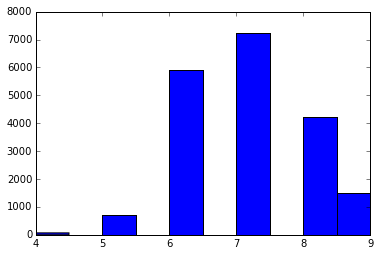

In [36]:
# dat with IP => to test for reliability on q10 (student self-assessed involvment in the course)

wrkld=dat[dat['three_evals']==1]['sum_q10']
plt.hist (wrkld)

    